In [5]:
# Need to pip install matplotlib, pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# Change root directory
dirPath = r'C:\Users\Andreas\Desktop\Thesis\Data'
os.chdir(dirPath)
print('Current working directory: {0}'.format(os.getcwd()))

Current working directory: C:\Users\Andreas\Desktop\Thesis\Data


In [24]:
def read_csv(dirPath = dirPath, sample = 'all', exercise = 'all'):
    root = dirPath+'\\'+'Unified'
    df = pd.DataFrame()

    for samplefolder in os.listdir(root):
        if sample in samplefolder or sample == 'all':

            for exercisefolder in os.listdir(root+'\\'+samplefolder):
                if exercise in exercisefolder or exercise == 'all':
                    
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):
                        if '.csv' in file:
                            csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                            data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')
                            df = pd.concat([df, data], ignore_index=True)
    return df

In [25]:
df = read_csv(sample='13')

Subject_12


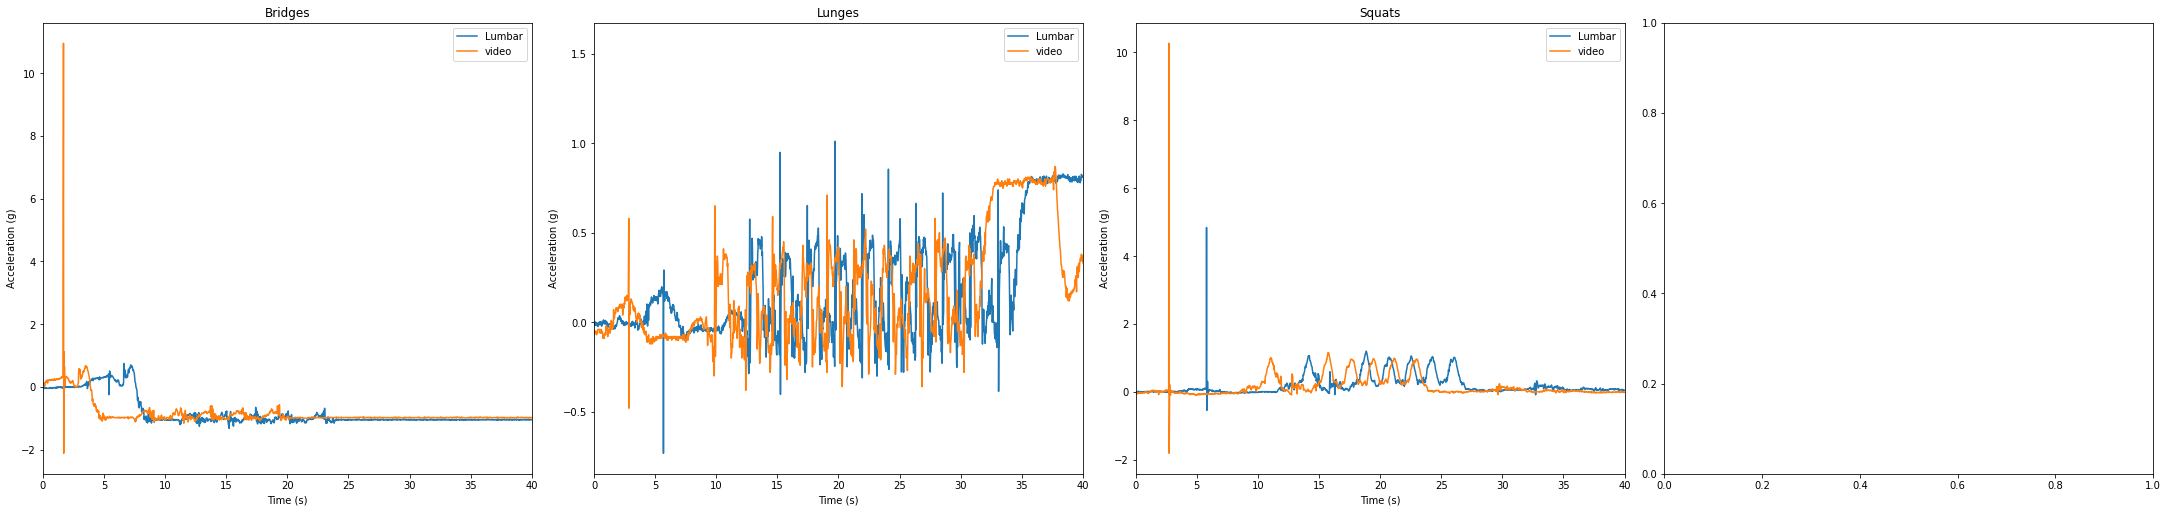

In [26]:
# Look for synchronization peaks
subject_groups = df.groupby('Subject')
for strSubject,dfSubject in subject_groups:
    print(strSubject)
    fig, ax = plt.subplots(nrows=1, ncols=4, layout="constrained", figsize=(30,7))
    i=0
    exercise_groups = dfSubject.groupby('Exercise')
    for strExercise, dfExercise in exercise_groups:

        datatype_groups = dfExercise.groupby('DataType')
        for strDatatype,dfDatatype in datatype_groups:
            if strDatatype == 'Acc': 

                sensor_groups = dfDatatype.groupby('SensorName')
                for strSensorName,dfSensorName in sensor_groups:
                    if strSensorName == 'video' or strSensorName == 'Lumbar':
                        ax[i].plot(dfSensorName.t, dfSensorName.z, label = strSensorName)
                        ax[i].set_xlabel("Time (s)")
                        ax[i].set_ylabel("Acceleration (g)")

                        ax[i].set_title(strExercise)
                        ax[i].set_xlim(0,40)
                        ax[i].legend()
        i += 1
    plt.show()

Subject_12


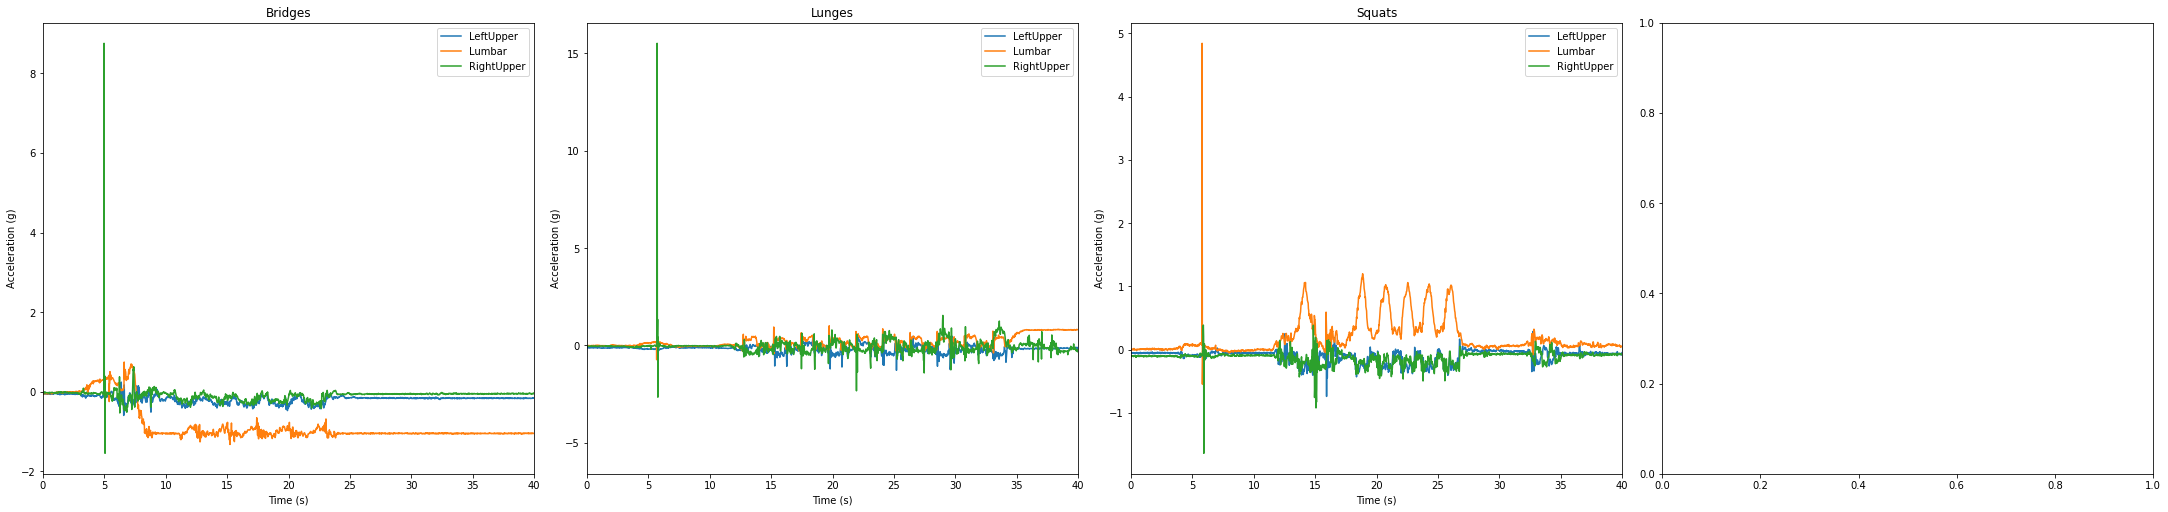

In [27]:
# Look for side of Upper leg synchronization tap
subject_groups = df.groupby('Subject')
for strSubject,dfSubject in subject_groups:
    print(strSubject)
    fig, ax = plt.subplots(nrows=1, ncols=4, layout="constrained", figsize=(30,7))
    i=0
    exercise_groups = dfSubject.groupby('Exercise')
    for strExercise, dfExercise in exercise_groups:

        datatype_groups = dfExercise.groupby('DataType')
        for strDatatype,dfDatatype in datatype_groups:
            if strDatatype == 'Acc': 

                sensor_groups = dfDatatype.groupby('SensorName')
                for strSensorName,dfSensorName in sensor_groups:
                    if strSensorName == 'Lumbar' or strSensorName == 'RightUpper'or strSensorName == 'LeftUpper':
                        ax[i].plot(dfSensorName.t, dfSensorName.z, label = strSensorName)
                        ax[i].set_xlabel("Time (s)")
                        ax[i].set_ylabel("Acceleration (g)")

                        ax[i].set_title(strExercise)
                        ax[i].set_xlim(0,40)
                        ax[i].legend()
        i += 1
    plt.show()

In [18]:
def synchronize_csv(UpperSyncLocation, lim, dirPath=dirPath, sample = 'all', exercise='all'):

    # Synchronize the data from different devices
    # Device 1: LeftUpper, RightUpper
    # Device 2: LeftLower, RightLower and Chest
    # Device 3: Video

    # Target format:
    # Subject, Exercise, SensorName, DataType, time, t, x, y, z

    # lim = Peak detection limit for spike in acceleration towards the body (z-direction)

    root = dirPath+'\\'+'Unified'
    for samplefolder in os.listdir(root):
        if sample in samplefolder or sample == 'all':

            for exercisefolder in os.listdir(root+'\\'+samplefolder):
                if exercise in exercisefolder or exercise == 'all':
                    tsync1 = tsync2 = tsync3 = -9999
                    # Find sync points for each device
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):
                        if 'Acc.csv' in file or 'accelerometer.csv' in file:
                            if UpperSyncLocation in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    # Find sync point
                                    sync1 = (np.abs(data.z) > lim).argmax()
                                    tsync1 = data.t[sync1]
                                
                            if 'Chest' in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    # Find sync point
                                    if not any (np.abs(data.z) > lim):
                                        print('No value is over limit in Chest')
                                    else:
                                        sync2 = (np.abs(data.z) > lim).argmax()
                                        tsync2 = data.t[sync2]


                            if 'accelerometer' in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    # Find sync point
                                    if not any (np.abs(data.z) > lim):
                                        print('No value is over limit in Video')
                                    else:
                                        sync3 = (np.abs(data.z) > lim).argmax()
                                        tsync3 = data.t[sync3]
                                        video_start_offset = data.t[sync3]
                                        # recfinish = data.t.iloc[-1]
                    
                    print(samplefolder,exercisefolder,'/aries (U,C)/', tsync1, '==',tsync2,'/cam/',tsync3)

                    # Drop data before sync point and after the recording is stopped
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):
                        if '.csv' in file:
                            if 'Upper' in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    # finish = (data.t > recfinish).argmax()
                                    # data = data.loc[sync1:finish]
                                    data = data.loc[sync1::]

                            if 'Lower' in file or 'Chest' in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    data = data.loc[sync2::]

                            if 'data_collection' in file:
                                csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                                data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                                if len(data) > 0:
                                    data = data.loc[sync3::]
                    
                            if len(data) > 0:
                                data = data.reset_index(drop=True)
                                
                                t = []
                                video_t = [] 
                                for value in data.t:
                                    # Reset to sync point
                                    after_sync = value-data.t[0]
                                    t.append(after_sync)
                                    # Reset to recording start
                                    video_t.append((after_sync+video_start_offset))
                                
                                data.insert(5, 'time', np.around(np.array(t),2))
                                data['t'] = np.around(np.array(video_t),2)
                                data = data.reset_index(drop=True)

                                new_root = dirPath+'\\'+'Synchronized'+'\\'+samplefolder+'\\'+exercisefolder
                                if not os.path.exists(new_root):
                                    os.makedirs(new_root)

                                data.to_csv(new_root+'\\'+file, sep=',', index=False)                                

In [28]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.5, sample= '12')

Subject_12 Bridges /aries (U,C)/ 4.976 == 5.457 /cam/ 1.66
Subject_12 Lunges /aries (U,C)/ 5.715 == 5.677 /cam/ 2.84
Subject_12 Squats /aries (U,C)/ 5.937 == 5.797 /cam/ 2.72


In [9]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.4, sample= '11')

Subject_11 Bridges /aries (U,C)/ 3.618 == 3.558 /cam/ 0.22
Subject_11 Lunges /aries (U,C)/ 23.986 == 24.006 /cam/ 1.7
Subject_11 Squats /aries (U,C)/ 7.955 == 7.894 /cam/ 3.08


In [20]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 1, sample= '10') # Manually fixed video squats to 4.4, Upper squats tp 7.416, Upper Bridges to 7.8

Subject_10 Bridges /aries (U,C)/ 7.916 == 7.813 /cam/ 3.68
Subject_10 Lunges /aries (U,C)/ 12.193 == 12.154 /cam/ 8.76
Subject_10 Squats /aries (U,C)/ 7.416 == 7.436 /cam/ 4.4


In [27]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.5, sample= '9')

Subject_9 Bridges /aries/ 5.177 == 5.037 /cam/ 3.8
Subject_9 Lunges /aries/ 5.177 == 5.117 /cam/ 2.22
Subject_9 Squats /aries/ 7.695 == 7.656 /cam/ 4.22


In [28]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.3, sample= '8')

Subject_8 Bridges /aries/ 8.575 == 8.475 /cam/ 1.86
Subject_8 Lunges /aries/ 14.334 == 14.37 /cam/ 5.2
Subject_8 Squats /aries/ 8.055 == 8.096 /cam/ 3.26


In [29]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.9, sample= '7')

Subject_7 Bridges 1 /aries/ 6.556 == 4.019 /cam/ 1.9
Subject_7 Bridges 2 /aries/ 18.97 == 0.7 /cam/ 2.82
Subject_7 Lunges /aries/ 5.157 == 3.837 /cam/ 2.02
Subject_7 Squats /aries/ 31.902 == 30.585 /cam/ 2.24


In [30]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 2, sample= '6')

Subject_6 Bridges 1 /aries/ 5.255 == 4.798 /cam/ 2.5
Subject_6 Bridges 2 /aries/ 4.818 == 5.177 /cam/ 2.2
Subject_6 Lunges /aries/ 6.876 == 6.856 /cam/ 3.24
Subject_6 Squats /aries/ 7.076 == 8.535 /cam/ 4.76


In [31]:
synchronize_csv(UpperSyncLocation= 'LeftUpper',lim = 1, sample= '5')

Subject_5 Bridges /aries/ 5.617 == 5.637 /cam/ 2.48
Subject_5 Lunges /aries/ 7.815 == 7.798 /cam/ 3.86
Subject_5 Squats /aries/ 9.235 == 9.193 /cam/ 2.66


In [44]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.6, sample= '4')

Subject_4 Bridges /aries/ 24.046 == 24.046 /cam/ 10.57
Subject_4 Lunges /aries/ 6.856 == 6.558 /cam/ 3.4
Subject_4 Squats /aries/ 8.875 == 8.795 /cam/ 3.14


In [33]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 1, sample= '3')

Subject_3 Bridges /aries/ 5.126 == 4.398 /cam/ 3.52
Subject_3 Lunges /aries/ 36.421 == 36.919 /cam/ 12.58
Subject_3 Squats /aries/ 7.575 == 7.976 /cam/ 2.26


In [9]:
synchronize_csv(UpperSyncLocation= 'RightUpper',lim = 0.8, sample= '2')

Subject_2 Bridges /aries/ 32.262 == 33.563 /cam/ 3.46
Subject_2 Lunges /aries/ 31.223 == 31.222 /cam/ 4.9
Subject_2 Squats /aries/ 19.729 == 20.568 /cam/ 7.3


In [29]:
def read_csv(dirPath = dirPath, sample = 'all', exercise = 'all'):
    root = dirPath+'\\'+'Synchronized'
    df = pd.DataFrame()

    for samplefolder in os.listdir(root):
        if sample in samplefolder or sample == 'all':

            for exercisefolder in os.listdir(root+'\\'+samplefolder):
                if exercise in exercisefolder or exercise == 'all':
                    
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):
                        if '.csv' in file:
                            csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                            data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')
                            df = pd.concat([df, data], ignore_index=True)
    return df


In [30]:
df = read_csv(sample='12')
# display(df)

Subject_12


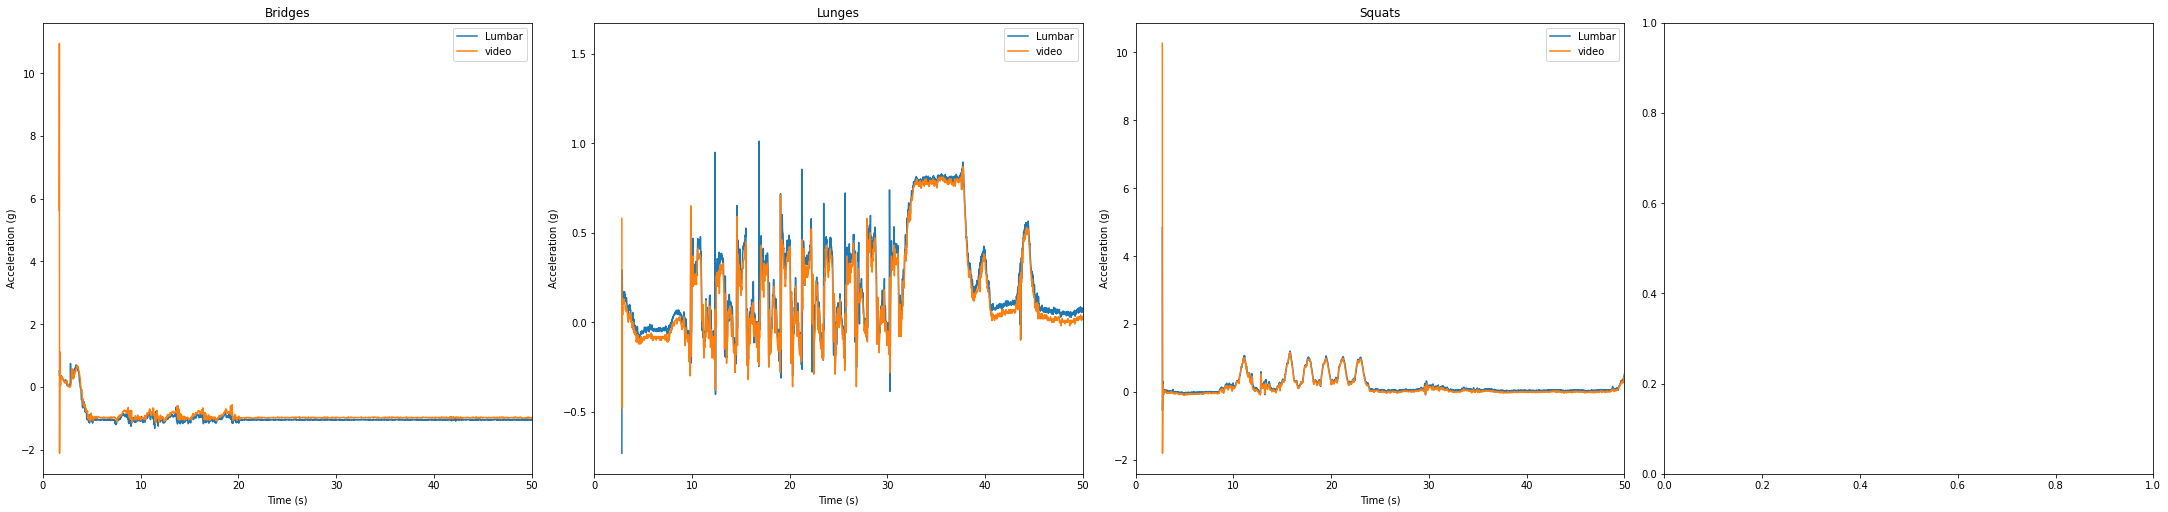

In [31]:
# Check if synced
subject_groups = df.groupby('Subject')
for strSubject,dfSubject in subject_groups:
    print(strSubject)
    fig, ax = plt.subplots(nrows=1, ncols=4, layout="constrained", figsize=(30,7))
    i=0
    exercise_groups = dfSubject.groupby('Exercise')
    for strExercise, dfExercise in exercise_groups:

        datatype_groups = dfExercise.groupby('DataType')
        for strDatatype,dfDatatype in datatype_groups:
            if strDatatype == 'Acc': 

                sensor_groups = dfDatatype.groupby('SensorName')
                for strSensorName,dfSensorName in sensor_groups:
                    if strSensorName == 'video' or strSensorName == 'Lumbar':
                        ax[i].plot(dfSensorName.t, dfSensorName.z, label = strSensorName)
                        ax[i].set_xlabel("Time (s)")
                        ax[i].set_ylabel("Acceleration (g)")

                        ax[i].set_title(strExercise)
                        ax[i].set_xlim(0,50)
                    
                        ax[i].legend()
        i += 1
    plt.show()